# Initialise main directory


In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
main_dir = '/content/gdrive/My Drive/UpworkNotebooks/Opera Files/'

!ls '{main_dir}'/.

Mounted at /content/gdrive
All_Data  Csv_Files	 Helper_Notebooks  Models
Audios	  Documentation  Main_Notebooks


# Install and import libraries

In [2]:
!pip install -q librosa
!pip install -q pysoundfile
!pip install -q -U keras-tuner

In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf

import keras_tuner as kt
from ast import literal_eval

import os
import sys
import time
import shutil
from joblib import dump, load

%matplotlib inline

import urllib.request as urllib2 # For python3
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import librosa
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
from PIL import Image
import seaborn as sns


from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Obtain features and labels


## Helper Functions

In [4]:
label_target = {('mezzosoprano dramatic', 3), ('contraltos', 0), ('soprano coloratura', 5), 
                ('soprano spinto', 9), ('soprano lyric', 7), ('mezzosoprano lyric', 4), ('mezzosoprano coloratura', 2),
                ('soprano dramatic', 6), ('soprano soubrette', 8), ('countertenor', 1)}

labels = [item[0] for item in label_target]
print(label_target)
print(labels)

def targets_to_labels(list_to_convert):
  labels=[]
  for item in list_to_convert:
    for label, target in label_target:
      if item == target:
        labels.append(label)
  return labels

#function for removing problematic classes
def remove_problematic(to_remove, processed_data):
  for subregister in to_remove:
    for label, target in label_target:
      if subregister==label:
        processed_data = processed_data[processed_data['class_label'] != target]
  return processed_data

{('contraltos', 0), ('soprano spinto', 9), ('soprano dramatic', 6), ('soprano soubrette', 8), ('countertenor', 1), ('soprano lyric', 7), ('mezzosoprano lyric', 4), ('mezzosoprano coloratura', 2), ('mezzosoprano dramatic', 3), ('soprano coloratura', 5)}
['contraltos', 'soprano spinto', 'soprano dramatic', 'soprano soubrette', 'countertenor', 'soprano lyric', 'mezzosoprano lyric', 'mezzosoprano coloratura', 'mezzosoprano dramatic', 'soprano coloratura']


In [11]:
#read from mfccs data
processed_data = pd.read_csv(main_dir + "Csv_Files/females_500.csv")
processed_data = processed_data.sample(frac=1)

# to_evaluate = ['mezzosoprano coloratura', 'soprano lyric', 'soprano dramatic', 'soprano spinto',  ]
# , 'soprano soubrette', 'mezzosoprano dramatic',,]

to_evaluate = ['mezzosoprano dramatic', 'countertenor', 'contraltos', 'mezzosoprano lyric']

to_remove = [item for item in labels if item not in to_evaluate]

processed_data = remove_problematic(to_remove, processed_data)
features = [literal_eval(processed_data['mfccs'].tolist()[i]) for i in range(len(processed_data))]
targets = processed_data["class_label"].tolist()
num_labels = len(set(targets))
print('Selected targets: ', set(targets))
print('Number of classes: ', num_labels )
print('To evaluate: ', to_evaluate)
print('Not considered: ', to_remove)

Selected targets:  {0, 1, 3, 4}
Number of classes:  4
To evaluate:  ['mezzosoprano dramatic', 'countertenor', 'contraltos', 'mezzosoprano lyric']
Not considered:  ['soprano spinto', 'soprano dramatic', 'soprano soubrette', 'soprano lyric', 'mezzosoprano coloratura', 'soprano coloratura']


# Creating PCA components


Components 	 Fraction of explained variance
	 1 	 0.4996720912877212
	 2 	 0.6047032747203416
	 3 	 0.6704326785717809
	 4 	 0.7230474145757575
	 5 	 0.7722040838782267
	 10 	 0.9024428324121763
	 20 	 0.9737122180275545
	 25 	 0.984597255521907
	 28 	 0.9889014161908363
	 30 	 0.990741144853262
	 32 	 0.9922584645692899
	 40 	 0.9961863384592887
	 50 	 0.9982553583068983




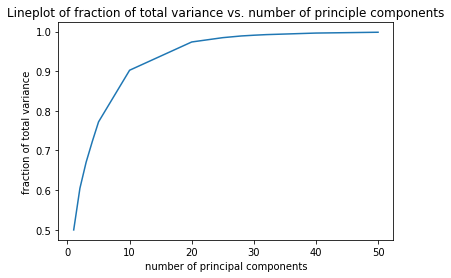

In [12]:
def get_pca_components(data):
  k = [1, 2, 3, 4, 5, 10, 20, 25, 28, 30, 32, 40, 50]
  explained_variances = []
  print('Components \t Fraction of explained variance')
  for components in k:
    pca = PCA(n_components = components)
    data_pc = pca.fit_transform(data)
    fraction_of_variance = sum(pca.explained_variance_ratio_)
    print('\t',components,'\t',fraction_of_variance)
    explained_variances.append(fraction_of_variance)
  print('\n')
  plt.plot(k, explained_variances)
  plt.xlabel("number of principal components")
  plt.ylabel("fraction of total variance")
  plt.title("Lineplot of fraction of total variance vs. number of principle components")
  plt.show()
  pass

get_pca_components(data = features)

# Train_Test_Split

In [13]:
components = 32
pca = PCA(n_components = components)
data_pca = pca.fit_transform(features)
dump(pca, main_dir + 'Models/Development/Females_A/PCA/Females_A_pca.joblib') 
print( data_pca[2])
print(data_pca.shape)


[ 95.54384066 -38.15027294   9.88838557  -8.03636048 -13.49055588
  40.14052523 -10.95910562  22.74238072  15.38530918 -15.48279293
 -12.47145197  12.52566854 -12.52208133 -14.76496643  -2.28609784
  -5.88646472  -1.55700669  13.90601573  -9.57105263  -9.83056697
  -8.93254897   4.24682076   4.01285675   3.47628256  -6.02387289
   1.94596831  -1.0148911    3.34897805  -5.39108991   0.43109284
   8.74579995   1.72442553]
(2004, 32)


In [14]:
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(data_pca)
dump(standard_scaler, main_dir + 'Models/Development/Females_A/Scaler/Females_A_scaler.joblib')
X = np.array(X)
y = np.array(targets)
y_encoded = LabelEncoder().fit_transform(y)
y_categorical = to_categorical(y_encoded)
 
mapping = list(set([item for item in zip(y_encoded, targets)]))
label_mapping = {}
for item in mapping:
  label_mapping[int(item[0])] = item[1]

dump(label_mapping, main_dir +  'Models/Development/Females_A/Reports/Females_A_label_mapping.joblib')

x_train, x_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.15)
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size = 0.18)

print('x_train: ',len(x_train))
print('y_train: ', len(y_train))
print('x_test: ',len(x_test))
print('y_test: ',len(y_test))
print('x_dev: ',len(x_dev))
print('y_dev: ',len(y_dev))

datasets = [x_train, y_train, x_test, y_test, x_dev, y_dev]
dataset_names = ['x_train', 'y_train', 'x_test', 'y_test', 'x_dev', 'y_dev']
for dataset, dataset_name in zip(datasets, dataset_names):
  df = pd.DataFrame(dataset)
  folder = dataset_name.split('_')[1].capitalize()
  df.to_csv(main_dir + 'Models/Development/Females_A/Data/{0}/Females_A_{1}.csv'.format(folder, dataset_name), index=False)


x_train:  1396
y_train:  1396
x_test:  301
y_test:  301
x_dev:  307
y_dev:  307


# Keras Tuner

In [11]:
def model_builder(hp):
  lower = 8
  upper = 144
  step = 4

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=(components), dtype=tf.float32,
                          name='input_embedding'))
  hp_units_1 = hp.Int('units_1', min_value=lower, max_value=upper, step=step)
  model.add(keras.layers.Dense(units=hp_units_1, activation='relu',name='dense_1'))
  # hp_reg_1 = hp.Float('regs_1', min_value=0.001, max_value=0.15, step=0.001)
  hp_dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.8, step=0.1)
  model.add(keras.layers.Dropout(hp_dropout_1))

  # kernel_regularizer=regularizers.l2(hp_reg_1)
  # Tune the number of units in the Second Dense layer
  hp_units_2 = hp.Int('units_2', min_value=lower, max_value=upper, step=step)
  model.add(keras.layers.Dense(units=hp_units_2, activation='relu', name='dense_2'))
  # hp_reg_2 = hp.Float('regs_2', min_value=0.001, max_value=0.15, step=0.001)
  hp_dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.8, step=0.1)
  model.add(keras.layers.Dropout(hp_dropout_2))

  hp_units_3 = hp.Int('units_3', min_value=lower, max_value=upper, step=step)
  model.add(keras.layers.Dense(units=hp_units_3, activation='relu', name='dense_3'))
  # hp_reg_3 = hp.Float('regs_3', min_value=0.001, max_value=0.15, step=0.001)
  hp_dropout_3 = hp.Float('dropout_3', min_value=0.1, max_value=0.8, step=0.001)
  model.add(keras.layers.Dropout(hp_dropout_3))


  hp_units_5 = hp.Int('units_5', min_value=lower, max_value=upper, step=step)
  # # hp_reg_3 = hp.Float('regs_3', min_value=0.001, max_value=0.1, step=0.001)
  # hp_dropout_5 = hp.Float('dropout_5', min_value=0.1, max_value=0.8, step=0.01)
  model.add(keras.layers.Dense(units=hp_units_5, activation='relu', name='dense_5'))
  # model.add(keras.layers.Dropout(hp_dropout_5))


  #Output_Layer
  model.add(keras.layers.Dense(num_labels, activation='softmax', name='output_layer'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[0.005, 1e-1, 1e-2, 1e-3, 1e-4])
  # hp_learning_rate = 0.001

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

  return model

In [ ]:

tuner_dir = main_dir + 'Main_Notebooks/Keras_Tuner_Approach/Females_Trials/Keras_Tuner/Females_A'
if os.path.exists(tuner_dir)==False:
  !mkdir "{tuner_dir}"

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=100,
                     factor=4,
                     directory=tuner_dir,
                     project_name='mk11')
print(tuner_dir)
print(tuner.project_name)

/content/gdrive/My Drive/UpworkNotebooks/Opera Files/Main_Notebooks/Keras_Tuner_Approach/Females_Trials/Keras_Tuner/Females_A
mk11


In [ ]:
!ls "{tuner_dir}"

mk0  mk1  mk10	mk11  mk2  mk3	mk4  mk5  mk6  mk7  mk8  mk9


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 8
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 144, 'step': 4, 'sampling': None}
dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.8, 'step': 0.1, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 144, 'step': 4, 'sampling': None}
dropout_2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.8, 'step': 0.1, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 144, 'step': 4, 'sampling': None}
dropout_3 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.8, 'step': 0.001, 'sampling': None}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 144, 'step': 4, 'sampling': None}
learning_rate (Choice)
{'default': 0.005, 'conditions': [], 'values': [0.005, 0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6)

In [ ]:
tuner.search(x_train, y_train, epochs=180, validation_data=(x_dev, y_dev), callbacks=[stop_early])

Trial 161 Complete [00h 00m 12s]
val_accuracy: 0.6570605039596558

Best val_accuracy So Far: 0.7031700015068054
Total elapsed time: 00h 08m 25s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps = tuner.get_best_hyperparameters()[0]


In [ ]:
print('Layer 1 units:', best_hps.get('units_1'))
# print('Layer1 l2 regularizer:', best_hps.get('regs_1'))
print('Layer1 dropout:', best_hps.get('dropout_1'))

print('Layer 2 units:', best_hps.get('units_2'))
# print('Layer2 l2 regularizer:', best_hps.get('regs_2'))
print('Layer 2 dropout:', best_hps.get('dropout_2'))

print('Layer 3 units:', best_hps.get('units_5'))
# print('Layer3 l2 regularizer:', best_hps.get('regs_3'))
# print('Layer3 dropout:', best_hps.get('dropout_3'))



# print('Layer5 units:', best_hps.get('units_5'))

print('Learning Rate:', best_hps.get('learning_rate'))

Layer 1 units: 120
Layer1 dropout: 0.1
Layer 2 units: 76
Layer 2 dropout: 0.30000000000000004
Layer 3 units: 140
Learning Rate: 0.005


In [ ]:
h_model = tuner.hypermodel.build(best_hps)
h_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 120)               3720      
                                                                 
 dropout_3 (Dropout)         (None, 120)               0         
                                                                 
 dense_2 (Dense)             (None, 76)                9196      
                                                                 
 dropout_4 (Dropout)         (None, 76)                0         
                                                                 
 dense_3 (Dense)             (None, 120)               9240      
                                                                 
 dropout_5 (Dropout)         (None, 120)               0         
                                                                 
 dense_5 (Dense)             (None, 140)              

In [ ]:
h_history = h_model.fit(x_train, y_train, validation_data=(x_dev, y_dev), epochs=180)

Epoch 1/180
57/57 [==============================] - 1s 7ms/step - loss: 1.4193 - accuracy: 0.4001 - val_loss: 1.1775 - val_accuracy: 0.5389
Epoch 2/180
57/57 [==============================] - 0s 3ms/step - loss: 1.1352 - accuracy: 0.5597 - val_loss: 1.0673 - val_accuracy: 0.5821
Epoch 3/180
57/57 [==============================] - 0s 3ms/step - loss: 0.9786 - accuracy: 0.6164 - val_loss: 1.0082 - val_accuracy: 0.6254
Epoch 4/180
57/57 [==============================] - 0s 3ms/step - loss: 0.8973 - accuracy: 0.6522 - val_loss: 0.9543 - val_accuracy: 0.6282
Epoch 5/180
57/57 [==============================] - 0s 3ms/step - loss: 0.7872 - accuracy: 0.7050 - val_loss: 0.9450 - val_accuracy: 0.6340
Epoch 6/180
57/57 [==============================] - 0s 4ms/step - loss: 0.7775 - accuracy: 0.7171 - val_loss: 0.9357 - val_accuracy: 0.6455
Epoch 7/180
57/57 [==============================] - 0s 4ms/step - loss: 0.7024 - accuracy: 0.7353 - val_loss: 0.9298 - val_accuracy: 0.6628
Epoch 8/180
5

# Build Model Manually


In [32]:
def manual_model_builder():

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=(components), dtype=tf.float32,
                          name='input_embedding'))
  # hp_units_1 = hp.Int('units_1', min_value=lower, max_value=upper, step=step)
  model.add(keras.layers.Dense(units=88, activation='relu',name='dense_1'))
  # hp_reg_1 = hp.Float('regs_1', min_value=0.001, max_value=0.15, step=0.001)
  # hp_dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.8, step=0.1)
  model.add(keras.layers.Dropout(0.5))

  # kernel_regularizer=regularizers.l2(hp_reg_1)
  # regularizers.l2(hp_reg_3),
  # Tune the number of units in the Second Dense layer
  # hp_units_2 = hp.Int('units_2', min_value=lower, max_value=upper, step=step)
  model.add(keras.layers.Dense(units=84, activation='relu', name='dense_2'))
  # hp_reg_2 = hp.Float('regs_2', min_value=0.001, max_value=0.15, step=0.001)
  # hp_dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.8, step=0.1)
  model.add(keras.layers.Dropout(0.3))

  # model.add(keras.layers.Dense(units=96, activation='relu', name='dense_3'))
  # # hp_reg_2 = hp.Float('regs_2', min_value=0.001, max_value=0.15, step=0.001)
  # # hp_dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.8, step=0.1)
  # model.add(keras.layers.Dropout(0.5))

  model.add(keras.layers.Dense(units=52, activation='relu', name='dense_4'))
  # hp_reg_2 = hp.Float('regs_2', min_value=0.001, max_value=0.15, step=0.001)
  # hp_dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.8, step=0.1)
  # model.add(keras.layers.Dropout(0.4))




  #Output_Layer
  model.add(keras.layers.Dense(num_labels, activation='softmax', name='output_layer'))
  hp_learning_rate = 0.0005

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

  return model

manual_model = manual_model_builder()
manual_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 88)                2904      
                                                                 
 dropout_12 (Dropout)        (None, 88)                0         
                                                                 
 dense_2 (Dense)             (None, 84)                7476      
                                                                 
 dropout_13 (Dropout)        (None, 84)                0         
                                                                 
 dense_4 (Dense)             (None, 52)                4420      
                                                                 
 output_layer (Dense)        (None, 4)                 212       
                                                                 
Total params: 15,012
Trainable params: 15,012
Non-trai

In [33]:
manual_history = manual_model.fit(x_train, y_train, validation_data=(x_dev, y_dev), epochs=160)

Epoch 1/160
44/44 [==============================] - 1s 7ms/step - loss: 1.4402 - accuracy: 0.2629 - val_loss: 1.3593 - val_accuracy: 0.2801
Epoch 2/160
44/44 [==============================] - 0s 3ms/step - loss: 1.3744 - accuracy: 0.3009 - val_loss: 1.3284 - val_accuracy: 0.3746
Epoch 3/160
44/44 [==============================] - 0s 4ms/step - loss: 1.3334 - accuracy: 0.3689 - val_loss: 1.2960 - val_accuracy: 0.4397
Epoch 4/160
44/44 [==============================] - 0s 4ms/step - loss: 1.2893 - accuracy: 0.4004 - val_loss: 1.2600 - val_accuracy: 0.4821
Epoch 5/160
44/44 [==============================] - 0s 3ms/step - loss: 1.2733 - accuracy: 0.4126 - val_loss: 1.2241 - val_accuracy: 0.5016
Epoch 6/160
44/44 [==============================] - 0s 3ms/step - loss: 1.2196 - accuracy: 0.4656 - val_loss: 1.1797 - val_accuracy: 0.5212
Epoch 7/160
44/44 [==============================] - 0s 3ms/step - loss: 1.1814 - accuracy: 0.4885 - val_loss: 1.1380 - val_accuracy: 0.5440
Epoch 8/160
4

# Model Performance


In [34]:
model = manual_model
history = manual_history

# model = h_model
# history = h_history


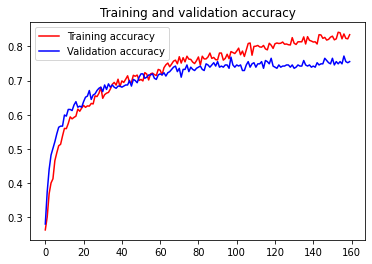

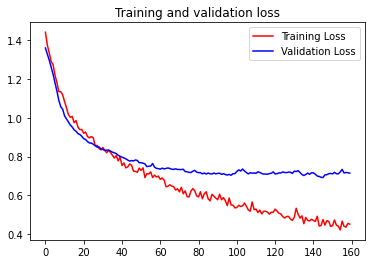

In [35]:
def model_performance(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')

  plt.legend()
  plt.show()
  pass

model_performance(history)


In [36]:
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)

10/10 [==============================] - 0s 2ms/step - loss: 0.6986 - accuracy: 0.7442
Test Loss:  0.6985536217689514
Test Accuracy:  0.7441860437393188


                       precision    recall  f1-score   support

           contraltos       0.75      0.84      0.79        79
         countertenor       0.85      0.68      0.75        88
mezzosoprano dramatic       0.66      0.69      0.67        70
   mezzosoprano lyric       0.72      0.78      0.75        64

             accuracy                           0.74       301
            macro avg       0.74      0.75      0.74       301
         weighted avg       0.75      0.74      0.74       301

0.9209377043243572
[0.92570419 0.92482928 0.8829932  0.95022416]


['/content/gdrive/My Drive/UpworkNotebooks/Opera Files/Models/Development/Females_A/Reports/Females_A_performance_report.joblib']

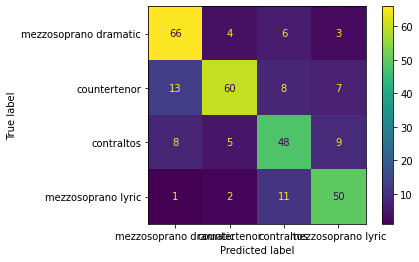

In [37]:
# model = keras.models.load_model(main_dir +  'Models/Development/Females_A/ANN/Females_A')

y_pred = model.predict(x_test)
y_pred_list = [y_pred[i].argmax() for i in range(len(x_test))]
y_true_list = [y_test[i].argmax() for i in range(len(x_test))]

label_mapping = load(main_dir +  'Models/Development/Females_A/Reports/Females_A_label_mapping.joblib')

y_pred_list = [label_mapping[item] for item in y_pred_list]
y_true_list = [label_mapping[item] for item in y_true_list]

true_labels = targets_to_labels(y_true_list)
pred_labels = targets_to_labels(y_pred_list)

conf_matrix = metrics.confusion_matrix(true_labels, pred_labels)
cm = metrics.ConfusionMatrixDisplay(conf_matrix, display_labels=to_evaluate).plot()
precision, recall, f_score, _ = metrics.precision_recall_fscore_support(y_true_list, y_pred_list, average='macro')
con_mat_norm = np.around(conf_matrix.astype('int') / conf_matrix.sum(axis=1)[:, np.newaxis], decimals=2)

performance_report = {}
performance_report['precision'] = precision
performance_report['recall'] = recall
performance_report['f_score'] = f_score
performance_report['conf_matrix'] = conf_matrix
performance_report['classification_report'] = metrics.classification_report(true_labels,pred_labels)
performance_report['avg_roc_auc_score'] = metrics.roc_auc_score(y_test,y_pred, multi_class='ovr')
performance_report['spcfc_roc_auc_score'] = metrics.roc_auc_score(y_test,y_pred, average=None ,multi_class='ovr')

print(performance_report['classification_report'])
print(performance_report['avg_roc_auc_score'])
print(performance_report['spcfc_roc_auc_score'])


dump(performance_report, main_dir +  'Models/Development/Females_A/Reports/Females_A_performance_report.joblib')

# Save the model

In [38]:
model.save(main_dir + 'Models/Development/Females_A/ANN/Females_A')
print('Develoment Model Saved')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/UpworkNotebooks/Opera Files/Models/Development/Females_A/ANN/Females_A/assets
Develoment Model Saved


# Save to Production

In [39]:
# Saving the acceptable model

dump(pca, main_dir + 'Models/Production/Females_A/PCA/Females_A_pca.joblib')
print('pca model saved') 
dump(standard_scaler, main_dir + 'Models/Production/Females_A/Scaler/Females_A_scaler.joblib')
print('scaler model saved') 
model.save(main_dir + 'Models/Production/Females_A/ANN/Females_A')
print('ANN model saved') 
dump(label_mapping, main_dir +  'Models/Production/Females_A/Reports/Females_A_label_mapping.joblib')
print('Label mapping saved')
dump(performance_report, main_dir +  'Models/Production/Females_A/Reports/Females_A_performance_report.joblib')
print('Performance report saved')


datasets = [x_train, y_train, x_test, y_test, x_dev, y_dev]
dataset_names = ['x_train', 'y_train', 'x_test', 'y_test', 'x_dev', 'y_dev']
for dataset, dataset_name in zip(datasets, dataset_names):
  df = pd.DataFrame(dataset)
  folder = dataset_name.split('_')[1].capitalize()
  df.to_csv(main_dir + 'Models/Production/Females_A/Data/{0}/Females_A_{1}.csv'.format(folder, dataset_name), index=False)
print('Datasets used saved') 


pca model saved
scaler model saved
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/UpworkNotebooks/Opera Files/Models/Production/Females_A/ANN/Females_A/assets
ANN model saved
Label mapping saved
Performance report saved
Datasets used saved
